# TOA SW CRE sampled on omega at 500hPa in free and locked CESM pre-industrial simulations

This notebook reproduces Fig. 2.

Data: free and locked control coupled atmosphere-ocean simulations with CESM, data provided from Brian Medeiros. These data have also been used, e.g., in [Grise et al. (2020)](https://doi.org/10.1029/2019GL083542).

### Load libraries

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

For reference, print package versions to screen:

In [2]:
print('xarrary:   ', xr.__version__)
print('numpy:     ', np.__version__)
import matplotlib; print('matplotlib:', matplotlib.__version__); del matplotlib

xarrary:    0.15.1
numpy:      1.18.1
matplotlib: 3.2.1


### Load CESM data for free and locked cloud simulations

In [3]:
def load_cesm_data_free(year1, year2):
    
    # omega at 500hPa, convert from Pa/s to hPa/day
    ds_omega = ( xr.load_dataset('../../data/cesm/B1850_c201_CTL.cam.h2.0001-01-01-00000.ncrcat.OMEGA500.nc').
                 sel(time=slice(year1, year2)).rename({'OMEGA500': 'omega'}).squeeze().drop('time_bnds') )
    ds_omega['omega'] = ds_omega['omega']*86400/100
    
    # sw cre at toa
    ds_toacresw = ( xr.load_dataset('../../data/cesm/B1850_c201_CTL.cam.h2.0001-01-01-00000.ncrcat.SWCF.nc').
                    sel(time=slice(year1, year2)).rename({'SWCF': 'toacresw'}).drop('time_bnds') )
    
    return xr.merge([ds_omega, ds_toacresw])

def load_cesm_data_lock(year1, year2):
    
    # omega at 500hPa, convert from Pa/s to hPa/day
    ds_omega = ( xr.load_dataset('../../data/cesm//B1850_c201_CLOCK.cam.h2.0001-01-01-00000.ncrcat.OMEGA500.nc').
                 sel(time=slice(year1, year2)).rename({'OMEGA500': 'omega'}).squeeze().drop('time_bnds') )
    ds_omega['omega'] = ds_omega['omega']*86400/100
    
    # sw cre at toa
    ds_toacresw = ( xr.load_dataset('../../data/cesm//B1850_c201_CLOCK.cam.h2.0001-01-01-00000.ncrcat.SWCF.nc').
                    sel(time=slice(year1, year2)).rename({'SWCF': 'toacresw'}).drop('time_bnds') )
    
    return xr.merge([ds_omega, ds_toacresw])

In [4]:
# load data, and also restrict to a subset of years
ds_free = load_cesm_data_free(year1='0002', year2='0010')
ds_lock = load_cesm_data_lock(year1='0002', year2='0010')

### Also Load land-sea mask
Note that pure ocean is land=0.

In [5]:
slm = xr.load_dataset('../../data/cesm/cesm2_f09_land.nc').rename({'LANDFRAC':'land'}).squeeze()

### Set all points that are not purely ocean points to nan

In [6]:
for i in range(slm.lon.size):
    for j in range(slm.lat.size):
        if slm['land'][j,i]>0.0:
            for ivar in ['omega', 'toacresw']:
                ds_free[ivar][:,j,i] = np.nan
                ds_lock[ivar][:,j,i] = np.nan

### Set up bins for omega-binning

In [7]:
# 5hPa/day wide omega bins with centers ranging from -97.5 to 97.5
bins_edges = 100*np.linspace(-1,1,41)
bins = bins_edges[0:40]+2.5

### Omega binning

In [8]:
def make_omega_sampling(omega, data, bins_edges):
    # define surface area weights
    weights   = ( omega*0.0 + 
                  np.expand_dims(np.cos(np.deg2rad(omega.lat)), axis=[0,2]) )
    # make omega histogram
    counts, _ = np.histogram( omega, bins=bins_edges, weights=weights, density=True )
    # for each entry of omega, indices gives the bin index it belongs to
    indices   = np.digitize(omega, bins)
    # resample data on omega bins
    data_sampled = np.zeros(bins.size)
    for ibin in range(bins.size):
        data_sampled[ibin] = ( np.nansum( data.values[indices==ibin] *
                                          weights.values[indices==ibin] ) /
                               np.nansum( weights.values[indices==ibin] ) )
    return counts, data_sampled

Compute binning over the Southern Hemisphere extratropics, defined by the northern and southern latitude boundaries.

In [9]:
latn=-30; lats=-90

Now call binning routine for daily-mean data

In [10]:
omega_free_pdf, toacresw_free_sampled = make_omega_sampling(ds_free['omega'].sel(lat=slice(lats,latn)),
                                               ds_free['toacresw'].sel(lat=slice(lats,latn)),
                                               bins_edges)
omega_lock_pdf, toacresw_lock_sampled = make_omega_sampling(ds_lock['omega'].sel(lat=slice(lats,latn)),
                                               ds_lock['toacresw'].sel(lat=slice(lats,latn)),
                                               bins_edges)

Now call binning routine for monthly-mean data

In [11]:
omega_free_mm_pdf, toacresw_free_mm_sampled = make_omega_sampling(
    ds_free['omega'].sel(lat=slice(lats,latn)).resample(time="1M").mean(),
    ds_free['toacresw'].sel(lat=slice(lats,latn)).resample(time="1M").mean(),
    bins_edges)
omega_lock_mm_pdf, toacresw_lock_mm_sampled = make_omega_sampling(
    ds_lock['omega'].sel(lat=slice(lats,latn)).resample(time="1M").mean(),
    ds_lock['toacresw'].sel(lat=slice(lats,latn)).resample(time="1M").mean(),
    bins_edges)

/home/fd8940/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


### Plotting

Only plot between -80 and 80 hPa/day (bins[4:36]), so as to avoid sampling issues for extreme omega values.

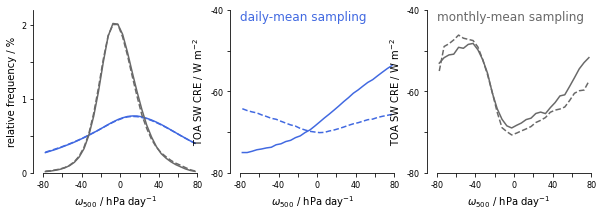

In [12]:
plt.figure(figsize=(10,3))

ax=plt.subplot(1,3,1)
ax.spines['left'].set_bounds(0,2.2)
ax.spines['bottom'].set_bounds(-80,80)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.plot(bins[4:36], 100*omega_free_pdf[4:36],'royalblue', label='free')
plt.plot(bins[4:36], 100*omega_lock_pdf[4:36],'royalblue', linestyle='--', label='lock')
plt.plot(bins[4:36], 100*omega_free_mm_pdf[4:36],'dimgray', label='free')
plt.plot(bins[4:36], 100*omega_lock_mm_pdf[4:36],'dimgray', linestyle='--', label='lock')
ax.xaxis.set_ticks([-80,-60,-40,-20,0,20,40,60,80])
ax.xaxis.set_ticklabels([-80,'',-40,'',0,'',40,'',80], fontsize=8)
ax.yaxis.set_ticks([0,0.5,1,1.5,2,2.5,3])
ax.yaxis.set_ticklabels([0,'',1,'',2,'',3], fontsize=8)
plt.xlabel(r'$\omega_{500}$ / hPa day$^{-1}$',fontsize=10)
plt.ylabel('relative frequency / %',fontsize=10)
plt.xlim(-90,80)
plt.ylim(0,2.2)

ax=plt.subplot(1,3,2)
ax.spines['left'].set_bounds(-80,-40)
ax.spines['bottom'].set_bounds(-80,80)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.plot(bins[4:36], toacresw_free_sampled[4:36],'royalblue')
plt.plot(bins[4:36], toacresw_lock_sampled[4:36],'royalblue', linestyle='--')
ax.xaxis.set_ticks([-80,-60,-40,-20,0,20,40,60,80])
ax.xaxis.set_ticklabels([-80,'',-40,'',0,'',40,'',80], fontsize=8)
ax.yaxis.set_ticks([-80,-70,-60,-50,-40])
ax.yaxis.set_ticklabels([-80,'',-60,'',-40], fontsize=8)
plt.xlabel(r'$\omega_{500}$ / hPa day$^{-1}$',fontsize=10)
plt.ylabel(r'TOA SW CRE / W m$^{-2}$',fontsize=10)
plt.xlim(-90,80)
plt.ylim(-80,-40)
plt.text(-80,-40, 'daily-mean sampling', size=12, color='royalblue', va='top', ha='left')

ax=plt.subplot(1,3,3)
ax.spines['left'].set_bounds(-80,-40)
ax.spines['bottom'].set_bounds(-80,80)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.plot(bins[4:36], toacresw_free_mm_sampled[4:36],'dimgray')
plt.plot(bins[4:36], toacresw_lock_mm_sampled[4:36],'dimgray', linestyle='--')
ax.xaxis.set_ticks([-80,-60,-40,-20,0,20,40,60,80])
ax.xaxis.set_ticklabels([-80,'',-40,'',0,'',40,'',80], fontsize=8)
ax.yaxis.set_ticks([-80,-70,-60,-50,-40])
ax.yaxis.set_ticklabels([-80,'',-60,'',-40], fontsize=8)
plt.xlabel(r'$\omega_{500}$ / hPa day$^{-1}$',fontsize=10)
plt.ylabel(r'TOA SW CRE / W m$^{-2}$',fontsize=10)
plt.xlim(-90,80)
plt.ylim(-80,-40)
plt.text(-80,-40, 'monthly-mean sampling', size=12, color='dimgray', va='top', ha='left')

plt.savefig('figure-2.pdf')